In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# New Pre-processing
from operator import index
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from fastai.tabular.all import df_shrink
from google.colab import data_table
from google.colab import files
from google.colab import drive
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.decomposition import  PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

testing = '/content/drive/MyDrive/Senior Database Files/KDDTest+.csv'
training = '/content/drive/MyDrive/Senior Database Files/KDDTrain+.csv'

train = pd.read_csv(training, encoding='utf-8')
test = pd.read_csv(testing, encoding='utf-8')




train = df_shrink(train, skip=[], obj2cat=True, int2uint=True)
test = df_shrink(test, skip=[], obj2cat=True, int2uint=True)


feature_type_map = {f: (train.dtypes.loc[f], test.dtypes.loc[f]) for f in train.columns}

len(train['class'].cat.categories), len(test['class'].cat.categories)

len(train.service.cat.categories), len(test.service.cat.categories)

def train_test_category_union(feature):
  tcl = len(train[feature].cat.categories)
  tcll = len(test[feature].cat.categories)
  feature_cat_union = train[feature].cat.categories.union(test[feature].cat.categories)
  train[feature] = train[feature].cat.set_categories(feature_cat_union)
  test[feature] = test[feature].cat.set_categories(feature_cat_union)

cat = list(train.select_dtypes(include='category').columns.values)

for f in cat:
  train_test_category_union(f)
le = LabelEncoder()
train['classification'] = le.fit_transform(train['class'])
test['classification'] = le.fit_transform(test['class'])
train.drop('class', axis=1, inplace=True)
test.drop('class', axis=1, inplace=True)
train['protocol_type'] = le.fit_transform(train['protocol_type'])
test['protocol_type'] = le.fit_transform(test['protocol_type'])
train['service'] = le.fit_transform(train['service'])
test['service'] = le.fit_transform(test['service'])
train['flag'] = le.fit_transform(train['flag'])
test['flag'] = le.fit_transform(test['flag'])
train['land'] = le.fit_transform(train['land'])
test['land'] = le.fit_transform(test['land'])
train['logged_in'] = le.fit_transform(train['logged_in'])
test['logged_in'] = le.fit_transform(test['logged_in'])
train['is_host_login'] = le.fit_transform(train['is_host_login'])
test['is_host_login'] = le.fit_transform(test['is_host_login'])
train['is_guest_login'] = le.fit_transform(train['is_guest_login'])
test['is_guest_login'] = le.fit_transform(test['is_guest_login'])

class_data_train = train['classification']

train_index = train.columns
mutual_info = mutual_info_classif(train, class_data_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = train_index
mutual_info.sort_values(ascending=False)
Select_features = SelectKBest(mutual_info_classif, k=30)
Select_features.fit(train, class_data_train)
new_col = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'classification']
train = train[new_col]
test = test[new_col]

#one hot encoding on all nominal categories except class
test = pd.get_dummies(test, columns=['protocol_type', 'service', 'flag', 'logged_in'])
train = pd.get_dummies(train, columns=['protocol_type', 'service', 'flag', 'logged_in'])

#robust scaling for normalization step
target_test = test['classification'].copy()
robust_scaler1 = RobustScaler()
robust_scaler2 = RobustScaler()
train.drop('classification', axis=1, inplace=True)
test.drop('classification', axis=1, inplace=True)
data1 = test.values[:, :]
data2 = train.values[:, :]
data1 = robust_scaler1.fit_transform(data1)
data2 = robust_scaler2.fit_transform(data2)
#converting array back to dataframe
test = pd.DataFrame(data1)
train = pd.DataFrame(data2)
#Preprocessing ends here

Train set class distribution:
class
normal     67343
anomaly    58630
Name: count, dtype: int64
Total train instances: 125973

Test set class distribution:
class
anomaly    12833
normal      9711
Name: count, dtype: int64
Total test instances: 22544
Train set class distribution:
class
normal     67343
anomaly    58630
Name: count, dtype: int64
Total train instances: 125973

Test set class distribution:
class
anomaly    12833
normal      9711
Name: count, dtype: int64
Total test instances: 22544


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

y_train_orig = train.iloc[:, -1]
y_test_orig = test.iloc[:, -1]

# Set -1 → 0 (anomaly), 0 → 1 (normal)
y_train_mapped = np.where(y_train_orig == -1, 0, 1)

# Set 0 → 0 (anomaly), 1 → 1 (normal)
y_test_mapped = np.where(y_test_orig == 0, 0, 1)


# Prepare features
X_train = train.iloc[:, :-1]
X_test = test.iloc[:, :-1]

# Good for model development but not good if we want this to be realistic.
# Combine all data and create a proper split
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = np.concatenate([y_train_mapped, y_test_mapped], axis=0)

# Create stratified split to maintain class distribution
X_train, X_test, y_train_mapped, y_test_mapped = train_test_split(
    X_combined, y_combined,
    test_size=0.3,
    stratify=y_combined,
    random_state=42
)

# Calculate scale_pos_weight for handling class imbalance
anomaly_count = np.sum(y_train_mapped == 0)
normal_count = np.sum(y_train_mapped == 1)
test_anomaly_count = np.sum(y_test_mapped == 0)
test_normal_count = np.sum(y_test_mapped == 1)
scale_pos_weight = normal_count / anomaly_count if anomaly_count > 0 else 1

# Initialize and train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,     # Num of trees
    max_depth=6,          # Max tree depth
    learning_rate=0.1,    # How quick it learns
    subsample=0.8,        # % of data per tree
    colsample_bytree=0.8, # % of features per tree
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'  # Evaluation metric
)


# Train the model
xgb_model.fit(
    X_train,
    y_train_mapped,
    eval_set=[(X_test, y_test_mapped)], # Evaluate on test set during training
    verbose=0
)

# Make predictions
y_pred = xgb_model.predict(X_test) # Final classifications (0 or 1)
# y_pred_proba = xgb_model.predict_proba(X_test) # Probability scores for both classes

# # Probability of being an anomaly (class 0)
# y_pred_proba_anomaly = y_pred_proba[:, 0]

# Evaluate the model
print("\n" + "="*50)
print("XGBoost Anomaly Detection Results")
print("="*50)
print("0 = Anomaly, 1 = Normal")

print(f"ROC AUC: {roc_auc_score(y_test_mapped, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_mapped, y_pred, target_names=['Anomaly (0)', 'Normal (1)']))



XGBoost Anomaly Detection Results
0 = Anomaly, 1 = Normal
Accuracy: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

 Anomaly (0)       1.00      1.00      1.00      3773
  Normal (1)       1.00      1.00      1.00     40783

    accuracy                           1.00     44556
   macro avg       1.00      1.00      1.00     44556
weighted avg       1.00      1.00      1.00     44556



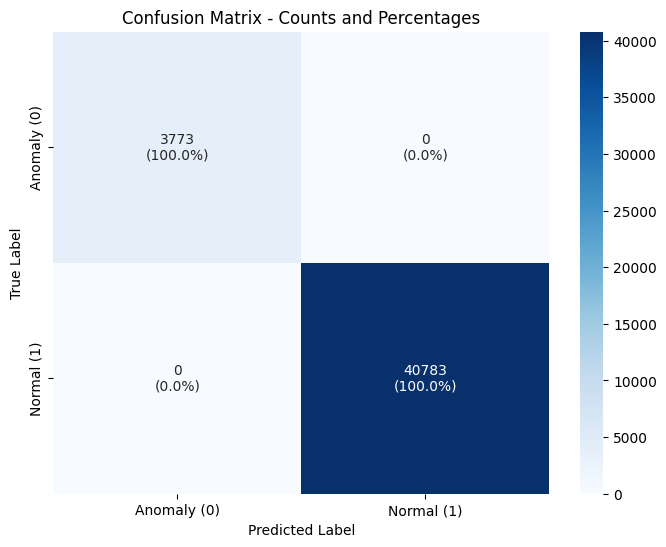

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred)

# Convert to percentages
cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100)

# Create labels with both counts and percentages
labels = np.array([["{0:d}\n({1:.1f}%)".format(count, percentage)
                   for count, percentage in zip(row_counts, row_percentages)]
                  for row_counts, row_percentages in zip(cm, cm_percentage)])

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Anomaly (0)', 'Normal (1)'],
            yticklabels=['Anomaly (0)', 'Normal (1)'])
plt.title('XGBoost Confusion Matrix - Counts and Percentages')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

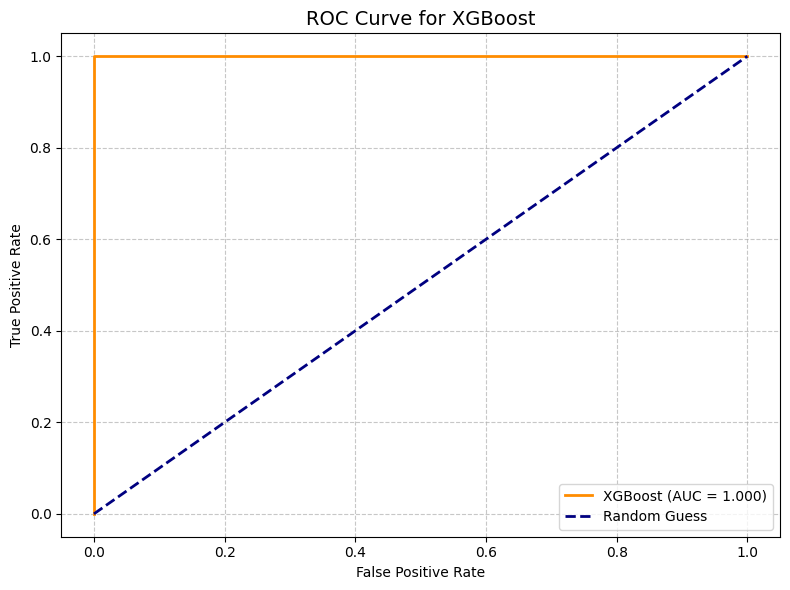

In [ ]:
# Get model probabilities
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_mapped, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.title('ROC Curve for XGBoost', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

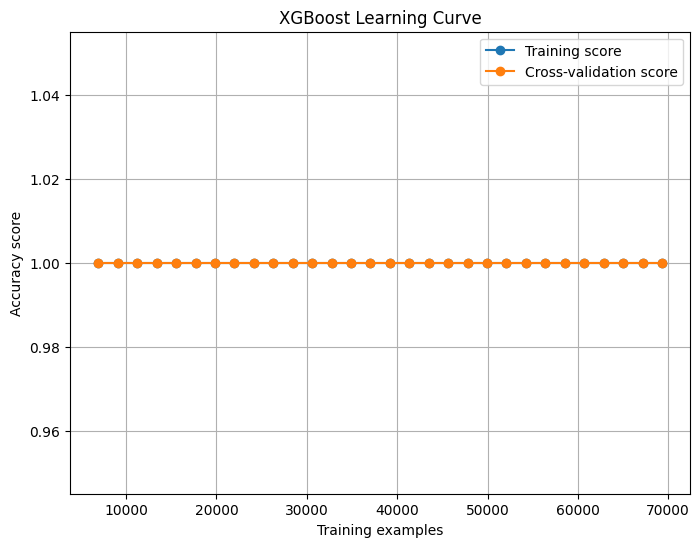

In [ ]:
# Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train_mapped, cv=3,
    train_sizes=np.linspace(0.1, 1.0, 30), scoring='accuracy'
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Accuracy score')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()